In [1]:
import os
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2

from tensorflow.keras.layers import (
    Dropout,
    Flatten,
    Dense,
    Input,
    Conv2D,
    MaxPooling2D,
)
from tensorflow.keras.preprocessing.image import (
    load_img,
    img_to_array,
)
from sklearn.model_selection import train_test_split
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from tqdm import tqdm

# Data preparation

In [2]:
annotations_data_path = "./data/annotations/"
images_data_path = "./data/images/"

In [3]:
target_size = (300, 300)

In [4]:
df = pd.DataFrame(
    columns=["img_path", "w", "h", "xmin", "ymin", "xmax", "ymax"]
)

## Load data into dataframe

In [5]:
for f in os.listdir(annotations_data_path):
    xml_tree = ET.parse(annotations_data_path + f)
    bbox_xml = xml_tree.getroot().find("object").find("bndbox")
    size_xml = xml_tree.getroot().find("size")
    w = int(size_xml.find("width").text)
    h = int(size_xml.find("height").text)

    xmin = int(bbox_xml.find("xmin").text)
    ymin = int(bbox_xml.find("ymin").text)
    xmax = int(bbox_xml.find("xmax").text)
    ymax = int(bbox_xml.find("ymax").text)

    img_path = images_data_path + xml_tree.getroot().find("filename").text
    new_row = pd.DataFrame(
        {
            "img_path": img_path,
            "w": w,
            "h": h,
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax,
        },
        index=[0],
    )

    df = pd.concat([df, new_row], ignore_index=True)
df

,img_path,w,h,xmin,ymin,xmax,ymax
0,./data/images/00009e5b390986a0_jpg.rf.5dc38ab1...,1024,682,472,604,514,624
1,./data/images/000228608388803f_jpg.rf.528e8a61...,1024,768,185,593,317,656
2,./data/images/00043e7c5c4c025a_jpg.rf.54e6ef03...,1024,768,787,388,864,440
3,./data/images/0005ea10e0e14db1_jpg.rf.25cdff2c...,1024,683,868,263,931,290
4,./data/images/0006dc0977056410_jpg.rf.c178fd68...,1024,964,399,690,507,714
...,...,...,...,...,...,...,...
4721,./data/images/rotatequandoi94_jpg.rf.6cafb9cbe...,640,480,367,315,403,348
4722,./data/images/rotatequandoi95_jpg.rf.b0a4669cb...,640,399,215,243,283,282
4723,./data/images/rotatequandoi96_jpg.rf.36d7829e5...,800,533,587,509,637,533
4724,./data/images/rotatequandoi97_jpg.rf.9635e2d80...,2000,1500,1235,820,1372,904


## Image preprocessing


In [6]:
images = []
bboxes = []

In [7]:
for idx, row in tqdm(df.iterrows()):
    img = load_img(row["img_path"])
    resized_img = img.resize(target_size)
    resized_array = img_to_array(resized_img)
    w = row["w"]
    h = row["h"]

    xmin = int(row["xmin"]) / w
    ymin = int(row["ymin"]) / h
    xmax = int(row["xmax"]) / w
    ymax = int(row["ymax"]) / h

    images.append(resized_array)
    bboxes.append([xmin, ymin, xmax, ymax])

4726it [00:16, 282.70it/s]


In [8]:
images = np.array(images, dtype='float32') / 255.0
bboxes = np.array(bboxes)

In [9]:
images_train, images_val, bboxes_train, bboxes_val = train_test_split(
    images, bboxes, test_size=0.2, random_state=42
)

In [10]:
images_val, images_test, bboxes_val, bboxes_test = train_test_split(
    images_val, bboxes_val, test_size=0.5
)

# SSD300

## Training model

In [11]:
from keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [12]:
def IoU(box1, box2):
    x1_inter = tf.maximum(
        tf.cast(box1[0], dtype=tf.float32), tf.cast(box2[0], dtype=tf.float32)
    )
    y1_inter = tf.maximum(
        tf.cast(box1[1], dtype=tf.float32), tf.cast(box2[1], dtype=tf.float32)
    )
    x2_inter = tf.minimum(
        tf.cast(box1[2], dtype=tf.float32), tf.cast(box2[2], dtype=tf.float32)
    )
    y2_inter = tf.minimum(
        tf.cast(box1[3], dtype=tf.float32), tf.cast(box2[3], dtype=tf.float32)
    )

    intersection_area = tf.maximum(
        0.0, x2_inter - x1_inter + 1.0
    ) * tf.maximum(0.0, y2_inter - y1_inter + 1.0)

    area_box1 = (box1[2] - box1[0] + 1.0) * (box1[3] - box1[1] + 1.0)
    area_box2 = (box2[2] - box2[0] + 1.0) * (box2[3] - box2[1] + 1.0)
    union_area = area_box1 + area_box2 - intersection_area

    iou = intersection_area / union_area

    return iou

### Baseline model

In [13]:
class SSD300:
    def __init__(
        self,
        input_size: tuple,
    ) -> None:
        base_model = self.__vgg19_implemented(input_size)
        print(type(base_model))
        flatten_output = Flatten()(base_model.output)
        bbox_layers = Dense(4096, activation="relu")(flatten_output)
        bbox_layers = Dense(4096, activation="relu")(bbox_layers)
        bbox_layers = Dense(1000, activation="relu")(bbox_layers)
        bbox_layers = Dropout(0.2)(bbox_layers)
        bounding_box = Dense(4, activation="sigmoid", name="bounding_box")(
            bbox_layers
        )

        model = Model(
            inputs=base_model.input,
            outputs=(bounding_box),
        )
        self.model = model

    def __vgg19_implemented(self, input_size):
        vgg19 = Sequential()
        vgg19.add(Input(shape=(*input_size, 3)))

        vgg19.add(Conv2D(64, (3, 3), activation="relu"))
        vgg19.add(Conv2D(64, (3, 3), activation="relu"))
        vgg19.add(MaxPooling2D())

        vgg19.add(Conv2D(128, (3, 3), activation="relu"))
        vgg19.add(Conv2D(128, (3, 3), activation="relu"))
        vgg19.add(MaxPooling2D())

        vgg19.add(Conv2D(256, (3, 3), activation="relu"))
        vgg19.add(Conv2D(256, (3, 3), activation="relu"))
        vgg19.add(Conv2D(256, (3, 3), activation="relu"))
        vgg19.add(Conv2D(256, (3, 3), activation="relu"))
        vgg19.add(MaxPooling2D())

        vgg19.add(Conv2D(512, (3, 3), activation="relu"))
        vgg19.add(Conv2D(512, (3, 3), activation="relu"))
        vgg19.add(Conv2D(512, (3, 3), activation="relu"))
        vgg19.add(Conv2D(512, (3, 3), activation="relu"))
        vgg19.add(MaxPooling2D())

        vgg19.add(Conv2D(512, (3, 3), activation="relu"))
        vgg19.add(Conv2D(512, (3, 3), activation="relu"))
        vgg19.add(Conv2D(512, (3, 3), activation="relu"))
        vgg19.add(Conv2D(512, (3, 3), activation="relu"))
        vgg19.add(MaxPooling2D())

        return vgg19

    def call(self):
        return self.model

In [14]:
ssd_base = SSD300(target_size).call()

ssd_base.summary()

<class 'keras.src.engine.sequential.Sequential'>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 296, 296, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 146, 146, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 144, 144, 128)     147584    
            

In [15]:
ssd_base.compile(
    optimizer=Adam(0.00001),
    loss="mse",
    metrics=["accuracy", IoU],
)

In [16]:
with tf.device("/CPU:0"):
    ssd_base.fit(
        images_train,
        bboxes_train,
        validation_data=(
            images_val,
            bboxes_val,
        ),
        epochs=5,
        batch_size=32,
        verbose=1,
    )

Epoch 1/5
119/119 [==============================] - 1264s 11s/step - loss: 0.0250 - accuracy: 0.5971 - IoU: 0.6357 - val_loss: 0.0189 - val_accuracy: 0.6723 - val_IoU: 0.6980
Epoch 2/5
119/119 [==============================] - 1231s 10s/step - loss: 0.0145 - accuracy: 0.7823 - IoU: 0.7190 - val_loss: 0.0138 - val_accuracy: 0.8203 - val_IoU: 0.7537
Epoch 3/5
119/119 [==============================] - 1227s 10s/step - loss: 0.0118 - accuracy: 0.8127 - IoU: 0.7400 - val_loss: 0.0122 - val_accuracy: 0.8288 - val_IoU: 0.7744
Epoch 4/5
119/119 [==============================] - 1226s 10s/step - loss: 0.0106 - accuracy: 0.8119 - IoU: 0.7731 - val_loss: 0.0115 - val_accuracy: 0.8224 - val_IoU: 0.7795
Epoch 5/5
119/119 [==============================] - 1224s 10s/step - loss: 0.0098 - accuracy: 0.8310 - IoU: 0.7851 - val_loss: 0.0113 - val_accuracy: 0.8457 - val_IoU: 0.7884


In [17]:
ssd_base.save("./model/ssd_base.h5")

c:\Users\ADMIN\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Transfer Learning model

In [ ]:
input_images = Input(shape=(300, 300, 3), name="input_images")

base_model = InceptionResNetV2(
    weights="imagenet", include_top=False, input_tensor=input_images
)
base_model.trainable = False
base_out = base_model.output
flatten_output = Flatten()(base_out)
bbox_layers = Dense(512, activation="relu")(flatten_output)
bbox_layers = Dense(256, activation="relu")(bbox_layers)
bbox_layers = Dense(128, activation="relu")(bbox_layers)
bbox_layers = Dropout(0.25)(bbox_layers)
bounding_box = Dense(4, activation="sigmoid", name="bounding_box")(bbox_layers)


model_ssd = Model(
    inputs=base_model.input,
    outputs=bounding_box,
)

model_ssd.summary()

In [ ]:
model_ssd.compile(
    optimizer=Adam(0.00001),
    loss="mse",
    metrics=[
        "accuracy",
        f1_m,
        precision_m,
        recall_m,
    ],
)

In [ ]:
with tf.device("/CPU:0"):
    model_ssd.fit(
        images_train,
        bboxes_train,
        validation_data=(
            images_val,
            bboxes_val,
        ),
        epochs=5,
        batch_size=32,
        verbose=1,
    )

In [ ]:
model_ssd.save("./model/tl_model.h5")

## Model Evaluation


For object detection we will use IoU to check the overlap of predicted box compare to true box

In [18]:
from keras.utils import get_custom_objects

get_custom_objects().update({'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m, 'IoU': IoU})

In [19]:
ssd_base_model = load_model("./model/ssd_base.h5")

In [20]:
base_pred = ssd_base_model.predict(images_test)

15/15 [==============================] - 34s 2s/step


In [34]:
for y_true, y_pred in zip(bboxes_test, base_pred):
    iou = IoU(y_true, y_pred)
    print(iou)
    

0.6431781089817414
0.9501645635031115
0.9031369586205062
0.3010965080505766
0.7434155547173582
0.806588987412695
0.6871029045114746
0.6894861876919625
0.8772322760330415
0.8589756346446031
0.9101101140252833
0.8494313920856218
0.8249566518264848
0.8527456859866034
0.9604060399090542
0.7739357288260353
0.8248460740735933
0.8707889915392979
0.9530365412528256
0.7990614258862607
0.5650038436222644
0.9130756628930461
0.5619017979168618
0.8891416961265548
0.8871173223998742
0.8209211602567432
0.4235426909683391
0.9334123757625548
0.822137717787448
0.9141780247426511
0.6214100943083698
0.43045437034890527
0.5698901014969552
0.891938846766544
0.8692778649196351
0.888662613000082
0.7458395863852199
0.3160391061682101
0.6727062066378864
0.7051143798463455
0.9481801435214844
0.6869890560896387
0.4884762626204708
0.8773686236314753
0.9319745488838668
0.9380522405354698
0.6418562967480387
0.8703212399222291
0.6574844234681245
0.8756082768243236
0.9694375311347846
0.7902679139411627
0.8630949812783

In [29]:
import random


random_num = random.randint(0, len(images_test))
test_img = images_test[random_num].copy()
x1, y1, x2, y2 = base_pred[random_num] * 300
x3, y3, x4, y4 = bboxes_test[random_num] * 300
cv2.rectangle(
    test_img,
    (int(x1), int(y1)),
    (int(x2), int(y2)),
    (255, 0, 0),
    2,
)
cv2.rectangle(
    test_img,
    (int(x3), int(y3)),
    (int(x4), int(y4)),
    (0, 255, 0),
    2,
)

array([[[0.49411765, 0.44313726, 0.47058824],
        [0.5137255 , 0.4627451 , 0.49019608],
        [0.52156866, 0.47058824, 0.49803922],
        ...,
        [0.52156866, 0.5137255 , 0.5176471 ],
        [0.5137255 , 0.5058824 , 0.50980395],
        [0.5019608 , 0.49411765, 0.49803922]],

       [[0.47843137, 0.42745098, 0.45490196],
        [0.49019608, 0.4392157 , 0.46666667],
        [0.5019608 , 0.4509804 , 0.47843137],
        ...,
        [0.52156866, 0.5176471 , 0.5176471 ],
        [0.5137255 , 0.50980395, 0.50980395],
        [0.5019608 , 0.49803922, 0.5019608 ]],

       [[0.47843137, 0.41960785, 0.44705883],
        [0.47843137, 0.41960785, 0.44705883],
        [0.4862745 , 0.42745098, 0.45490196],
        ...,
        [0.5176471 , 0.52156866, 0.50980395],
        [0.5058824 , 0.5137255 , 0.5019608 ],
        [0.5019608 , 0.5058824 , 0.49411765]],

       ...,

       [[0.25882354, 0.26666668, 0.2627451 ],
        [0.26666668, 0.27450982, 0.27058825],
        [0.2784314 , 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(close=None, block=None)>

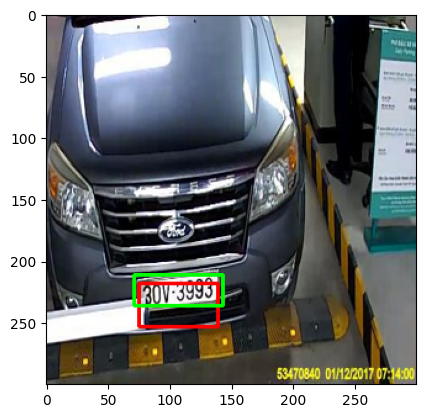

In [30]:
plt.imshow(test_img)
plt.show

In [46]:
tl_model = load_model("./model/tl_model.h5")

In [47]:
tl_pred = tl_model.predict(images_test)

15/15 [==============================] - 30s 2s/step


In [48]:
for y_true, y_pred in zip(bboxes_test, tl_pred):
    iou = IoU(y_true, y_pred)
    print(iou)

0.8647691752092892
0.8609088357241571
0.9436937078955809
0.483473789409458
0.8246960289041569
0.8730399191197952
0.802168513316805
0.8069026131606626
0.9162160550484049
0.9008400697364706
0.8238541845217141
0.9095358266083384
0.9431864360305434
0.9416253854540585
0.8635323590326932
0.8911738044748349
0.9515359869119635
0.9202346304655427
0.9533112469748323
0.9017494255670797
0.5092960108658644
0.9305543802696223
0.7154890034533943
0.9048327740759409
0.9484045774736374
0.8169154092596708
0.45025292408529793
0.8596988474104906
0.9262029542938917
0.8669439394951852
0.8235207458950741
0.5440870678752924
0.6955758122968904
0.960456291353878
0.9418516185983069
0.9112555261685826
0.9531317798014696
0.4977338213275692
0.8613712367036351
0.836872760684326
0.9438631954918472
0.845426968584965
0.6574431829988334
0.8171531267739156
0.9659746947407473
0.8370809139578805
0.8545688455828881
0.8476234499070129
0.9501853372195845
0.962948098281919
0.8969680487753917
0.8765704123961363
0.841958642439826

In [49]:
test_img_tl = images_test[random_num].copy()
x1, y1, x2, y2 = tl_pred[random_num] * 300
x3, y3, x4, y4 = bboxes_test[random_num] * 300
cv2.rectangle(
    test_img_tl,
    (int(x1), int(y1)),
    (int(x2), int(y2)),
    (255, 0, 0),
    2,
)
cv2.rectangle(
    test_img_tl,
    (int(x3), int(y3)),
    (int(x4), int(y4)),
    (0, 255, 0),
    2,
)

array([[[0.54509807, 0.42745098, 0.43529412],
        [0.5529412 , 0.43529412, 0.44313726],
        [0.54509807, 0.42745098, 0.43529412],
        ...,
        [0.03137255, 0.02352941, 0.04705882],
        [0.01176471, 0.00392157, 0.02745098],
        [0.1882353 , 0.18039216, 0.20392157]],

       [[0.54509807, 0.42745098, 0.43529412],
        [0.5529412 , 0.43529412, 0.44313726],
        [0.54509807, 0.42745098, 0.43529412],
        ...,
        [0.01568628, 0.00784314, 0.03137255],
        [0.        , 0.        , 0.01568628],
        [0.24313726, 0.23137255, 0.25882354]],

       [[0.54901963, 0.43137255, 0.4392157 ],
        [0.5529412 , 0.43529412, 0.44313726],
        [0.54509807, 0.42745098, 0.43529412],
        ...,
        [0.01176471, 0.00784314, 0.02745098],
        [0.01176471, 0.00784314, 0.02745098],
        [0.32156864, 0.31764707, 0.3372549 ]],

       ...,

       [[0.5803922 , 0.5686275 , 0.5411765 ],
        [0.58431375, 0.57254905, 0.54509807],
        [0.58431375, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(close=None, block=None)>

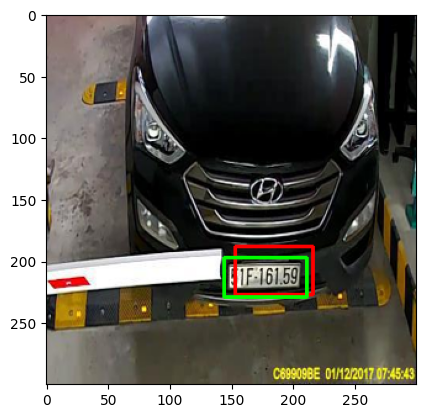

In [50]:
plt.imshow(test_img_tl)
plt.show

### Prediction

In [51]:
def plate_detection(path, model, size):
    ima = load_img(path)
    resized_image = ima.resize(size)

    resized_array = img_to_array(resized_image) / 255.0
    test_arr = resized_array.reshape(1, size[0], size[1], 3)

    prediction = model.predict(test_arr)
    predicted_bbox = prediction * 300
    predicted_bbox = np.array(predicted_bbox[0], dtype=np.uint8)
    xmin, ymin, xmax, ymax = predicted_bbox
    cv2.rectangle(resized_array, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    return resized_array, predicted_bbox

#### Base model


In [52]:
test_img_path = "./data/test_card.png"
image, prediction = plate_detection(test_img_path, ssd_base_model, target_size)

1/1 [==============================] - 0s 114ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


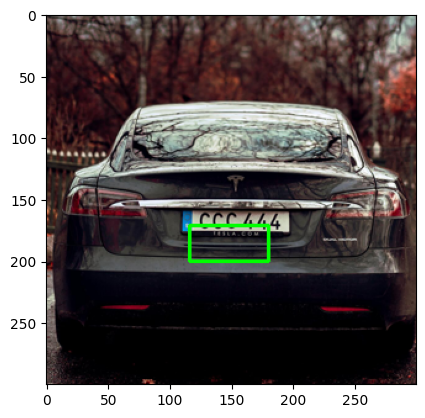

In [53]:
plt.imshow(image)
plt.show()

#### Transfer Learning


In [54]:
test_img_path = "./data/test_card.png"
image, prediction = plate_detection(test_img_path, tl_model, target_size)

1/1 [==============================] - 0s 169ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


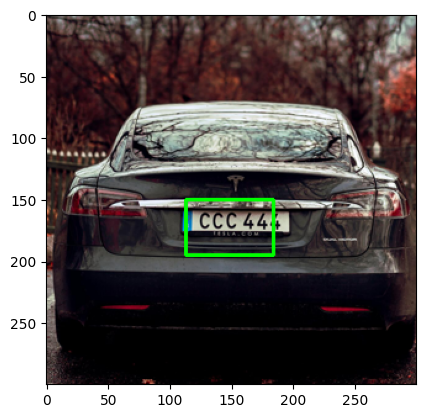

In [55]:
plt.imshow(image)
plt.show()

# YOLOv8


## Data Preparasion

In [ ]:
from ultralytics import YOLO
from random import shuffle
import shutil

In [ ]:
yolo_model = YOLO('yolov8n.pt')

### Convert Pascal VOC to YOLO Style


In [ ]:
os.makedirs("./data/labels", exist_ok=True)

In [ ]:
def pascal_voc_to_yolo(x1, y1, x2, y2, image_w, image_h):
    return [
        ((x2 + x1) / (2 * image_w)),
        ((y2 + y1) / (2 * image_h)),
        (x2 - x1) / image_w,
        (y2 - y1) / image_h,
    ]

In [ ]:
for file in os.listdir(annotations_data_path):
    xml_tree = ET.parse(annotations_data_path + file)
    bbox_xml = xml_tree.getroot().find("object").find("bndbox")
    size_xml = xml_tree.getroot().find("size")
    w = int(size_xml.find("width").text)
    h = int(size_xml.find("height").text)

    xmin = int(bbox_xml.find("xmin").text)
    ymin = int(bbox_xml.find("ymin").text)
    xmax = int(bbox_xml.find("xmax").text)
    ymax = int(bbox_xml.find("ymax").text)

    yolo_box = pascal_voc_to_yolo(xmin, ymin, xmax, ymax, w, h)
    lf = open(f"./data/labels/{file.split('.')[0]}.txt", "x")
    lf = open(f"./data/labels/{file.split('.')[0]}.txt", "w")
    lf.write(
        f"0 {yolo_box[0]} {yolo_box[1]} {yolo_box[2]} {yolo_box[3]}"
    )

In [ ]:
labels_path = "./data/labels/"

In [ ]:
train_dir = "./data/train/"
val_dir = "./data/valid/"
os.makedirs(train_dir + "/images", exist_ok=True)
os.makedirs(train_dir + "/labels", exist_ok=True)
os.makedirs(val_dir + "/images", exist_ok=True)
os.makedirs(val_dir + "/labels", exist_ok=True)

In [ ]:
files = os.listdir(images_data_path)
shuffle(files)

In [ ]:
def split(files, ratio):
    elements = len(files)
    middle = int(elements * ratio)
    return [files[:middle], files[middle:]]


def copy_files(images_path, labels_path, destination_path, files):
    for file_name in files:
        if "_jpg" in file_name:
            new_path = file_name.split(".")[0]
            src = images_path + f"{file_name}"
            dst = destination_path + "/images/" + new_path + ".jpg"
            shutil.copy(src, dst)

            src = labels_path + f"{new_path}.txt"
            dst = destination_path + "/labels"
            shutil.copy(src, dst)
        else:
            file_name = file_name.split(".")[0]

            src = images_path + f"{file_name}.png"
            dst = destination_path + "/images"
            shutil.copy(src, dst)

            src = labels_path + f"{file_name}.txt"
            dst = destination_path + "/labels"
            shutil.copy(src, dst)

In [ ]:
train_ratio = 0.8
train_files, val_files = split(files, train_ratio)

copy_files(images_data_path, labels_path, train_dir, train_files)
copy_files(images_data_path, labels_path, val_dir, val_files)

### Create training yaml file

In [ ]:
with open(f"./data/training_data.yaml", "w") as f:
    f.write("train: ./train/images\n")
    f.write("val: ./valid/images\n")
    f.write("nc: 1\n")
    f.write("names: {0: 'plate'}")

In [ ]:
results = yolo_model.train(
    data="./data/training_data.yaml", epochs=20, imgsz=320
)
results = yolo_model.val()

## Load yolo model


In [ ]:
loaded_yolo_model = YOLO("./runs/detect/train11/weights/best.pt")

In [ ]:
loaded_yolo_model(
    "./data/pexels_videos_2103099 (2160p).mp4",
    imgsz=320,
    save=True,
)